In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sql
import pymysql
import sklearn.linear_model as skllm
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
import scipy.signal as sps
import time

%matplotlib inline

In [2]:
sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

In [3]:
#connect to db
zidisha_db = qdb.QueryDatabase('zidisha')

In [4]:
sql_dir = 'SQL_queries'

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

sql_query_short = lambda x: zidisha_db.source_query(sql_dir, x, where_filter_col='country_name', where_filter_list=list_countries)

# Accepted borrower account creation dates
list_df_new_borrowers = sql_query_short('borrowers_w_countries.sql')
for df in list_df_new_borrowers:
    df.insert(0, 'Number of new borrowers', range(len(df)))

# Borrower first loan creation dates
list_df_first_loans = sql_query_short('first_loans_w_countries.sql')
for df in list_df_first_loans:
    df.insert(0, 'Number of first loans', range(len(df)))

# Time to funding
list_df_time_to_fund = sql_query_short('time_to_funding.sql')
    
# Time to disbursement
list_df_time_to_disbursement = sql_query_short('time_to_disbursement.sql')
    
# All loans
list_df_all_loans = sql_query_short('all_loans.sql')

# Fully funded loans
list_df_fully_funded_loans = sql_query_short('fully_funded_loans.sql')

# Load exchange rates
list_df_exchange_start = sql_query_short('exchange_rates_start.sql')

# Invited loans
list_df_invited_loans = sql_query_short('invitee_new_loans.sql')

In [5]:
#time_bins_edge = pd.date_range('2015-03-01','2015-09-01', None, '2W')

#time_bins_edge = pd.date_range('2013-12-01','2015-09-01', None, '2W')
#time_bins_edge = pd.date_range('2014-04-01','2015-09-01', None, '2W')

time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, 'W')
#time_bins_edge = pd.date_range('2013-04-01','2015-09-01', None, '3W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str, col_index=0: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, col_to_bin=col_index, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

df_time_to_fund = bin_short(list_df_time_to_fund, 'median')
df_time_to_fund_max = bin_short(list_df_time_to_fund, 'max')
df_time_to_disbursement = bin_short(list_df_time_to_disbursement, 'median')

df_usd_requested = bin_short(list_df_all_loans, 'sum', 0)
df_raised_fraction = bin_short(list_df_all_loans, 'median', 1)
df_usd_inflow = bin_short(list_df_all_loans, 'sum', 2)
df_usd_secured = bin_short(list_df_all_loans, 'sum', 3)
df_secured_fraction = df_usd_secured / df_usd_requested
df_usd_unsecured = df_usd_inflow - df_usd_secured

df_usd_requested_new = bin_short(list_df_first_loans, 'sum', 2)
df_raised_fraction_new = bin_short(list_df_first_loans, 'median', 3)
df_usd_inflow_new = bin_short(list_df_first_loans, 'sum', 4)
df_usd_secured_new = bin_short(list_df_first_loans, 'sum', 5)
df_secured_fraction_new = df_usd_secured_new / df_usd_requested_new
df_usd_unsecured_new = df_usd_inflow_new - df_usd_secured_new
df_usd_unsecured_new_fraction = df_usd_unsecured_new / df_usd_unsecured

df_usd_requested_new_frac = df_usd_requested_new / df_usd_requested
df_usd_secured_new_frac = df_usd_secured_new / df_usd_secured

df_invitee_first_loan_count = bin_short(list_df_invited_loans, 'count')
df_invitee_first_loan_frac = df_invitee_first_loan_count / df_first_loans_count

# Policies
df_loan_loss_fee_kenya = load_Zidisha.loan_loss_reserve_fee_Kenya(time_bins_center)
df_loan_loss_fee_other = load_Zidisha.loan_loss_reserve_fee_Other(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)
df_website_change = load_Zidisha.website_change(time_bins_center)

In [ ]:
np.searchsorted(list_df_new_borrowers[0].index.values, time_bins_edge.values)

In [6]:
%prun df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')

In [6]:
%timeit df_total_borrowers = bin_short(list_df_new_borrowers, 'count')

100 loops, best of 3: 11.5 ms per loop


In [8]:
# Calculate max and median values of loan fraction fulfilled for loans that failed
list_df_raised_some = []
list_df_raised_zero = []
for df in list_df_all_loans:
    df_temp = df.ix[(df['raised_fraction'] > 0.0) & (df['raised_fraction'] < 1.0), ['raised_fraction']]
    list_df_raised_some.append(df_temp)
    df_temp = df.ix[df['raised_fraction'] == 0.0, ['raised_fraction']]
    list_df_raised_zero.append(df_temp)
df_raised_some_median = bin_short(list_df_raised_some, 'median')
df_raised_some_count = bin_short(list_df_raised_some, 'count')
df_raised_some_max = bin_short(list_df_raised_some, 'max')

df_raised_zero_count = bin_short(list_df_raised_zero, 'count')


list_df_raised_some_new = []
list_df_raised_zero_new = []
for df in list_df_first_loans:
    df_temp = df.ix[(df['raised_fraction'] > 0.0) & (df['raised_fraction'] < 1.0), ['raised_fraction']]
    list_df_raised_some_new.append(df_temp)
    df_temp = df.ix[df['raised_fraction'] == 0.0, ['raised_fraction']]
    list_df_raised_zero_new.append(df_temp)
df_raised_some_new_median = bin_short(list_df_raised_some_new, 'median')
df_raised_some_new_count = bin_short(list_df_raised_some_new, 'count')
df_raised_some_new_max = bin_short(list_df_raised_some_new, 'max')

df_raised_zero_new_count = bin_short(list_df_raised_zero_new, 'count')

# Calculate median interest rates on fully funded first loans
list_df_first_loans_fully_funded = []
for df in list_df_first_loans:
    df_temp = df.ix[df['raised_fraction'] == 1.0, ['lender_interest_rate']]
    list_df_first_loans_fully_funded.append(df_temp)
df_first_loan_interest = bin_short(list_df_first_loans_fully_funded, 'median')

In [ ]:
df_first_loan_interest.plot()

In [ ]:
df_time_to_fund_max['All'].plot()

In [ ]:
df_raised_some_median.All.plot()
df_raised_some_max.All.plot()
df_raised_some_count[['All']].plot()

In [ ]:
list_df_first_loans[0]['Number of first loans'].plot(logy=True)

In [ ]:
df_raised_some_count['All'].plot()
df_raised_zero_count['All'].plot()
df_raised_some_new_count['All'].plot()
df_raised_zero_new_count['All'].plot()

In [ ]:
df_raised_some_new_count['All'].plot()
df_raised_zero_new_count['All'].plot()

In [ ]:
df_raised_some_median.All.plot()
df_raised_some_max.All.plot()
df_raised_some_count[['All']].plot()

In [ ]:
dft = list_df_all_loans[0]
dft.ix[(0.0<dft['raised_fraction']) & (dft['raised_fraction']<1.0), ['raised_fraction', 'usd_inflow']]


In [ ]:
df_usd_requested_new_frac[['All','Kenya']].plot()
df_usd_secured_new_frac[['All','Kenya']].plot()

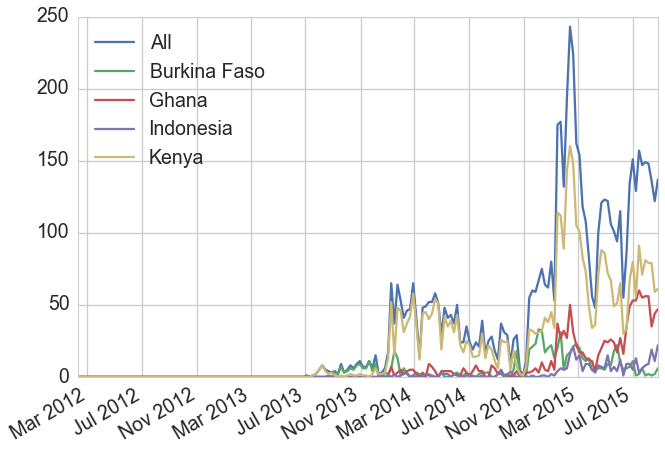

In [9]:
df_invitee_first_loan_count.plot()

In [7]:
df_invitee_first_loan_frac.ix[150,'Kenya']

0.6785714285714286

In [7]:
df_invitee_first_loan_frac.ix[150,'Kenya']

0.6785714285714286

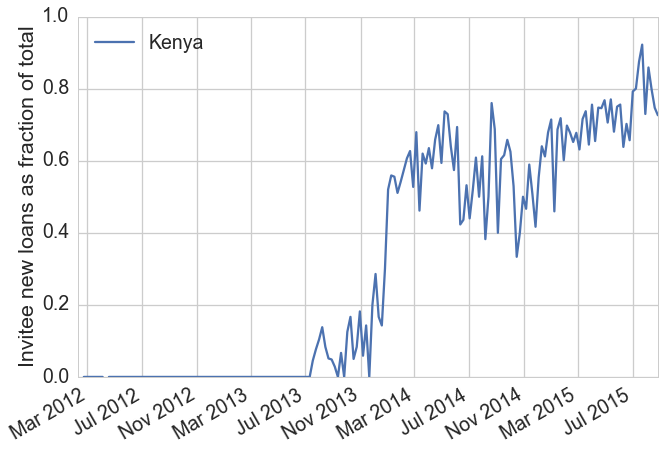

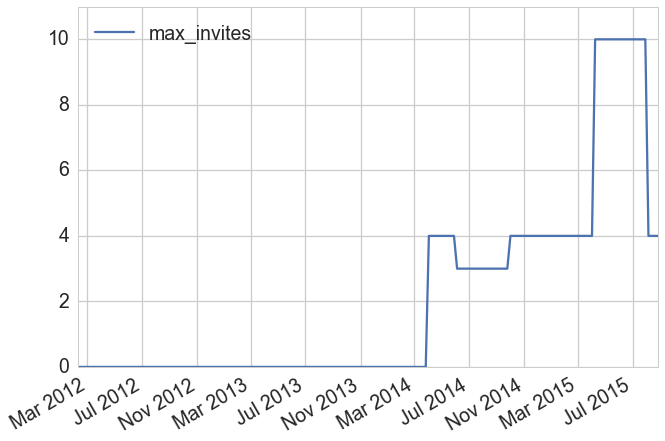

In [11]:
df_invitee_first_loan_frac[['Kenya']].plot()
plt.ylabel('Invitee new loans as fraction of total')
df_max_invites.plot()
plt.ylim([0,11]);

In [ ]:
df_secured_fraction[['All','Kenya']].plot()
df_fund_rate[['All','Kenya']].plot()

In [ ]:
df_usd_requested.plot()

In [ ]:
str_country = 'All'
df_money = pd.DataFrame({'Requested by '+str_country: df_usd_requested[str_country],
                         'Inflow to '+str_country: df_usd_inflow[str_country],
                         'Secured by '+str_country: df_usd_secured[str_country]},
                        columns=['Requested by '+str_country,
                         'Inflow to '+str_country,
                         'Secured by '+str_country])
df_money.plot()
df_secured_fraction[[str_country]].plot()
df_unsecured = pd.DataFrame({'Total unsecured': df_usd_unsecured[str_country],
                             'New loan unsecured': df_usd_unsecured_new[str_country]},
                        columns=['Total unsecured',
                         'New loan unsecured'])
df_unsecured.plot()

In [ ]:
df_time_to_disbursement.All.plot()

In [ ]:
df_time_to_fund[['All', 'Kenya']].plot()

In [ ]:
df_total_borrowers.plot()

In [ ]:
df_fund_rate[['All','Kenya']].plot()
plt.ylabel('Fraction of loans fully funded')

In [ ]:
df_first_loans_count.columns.tolist().remove('All')

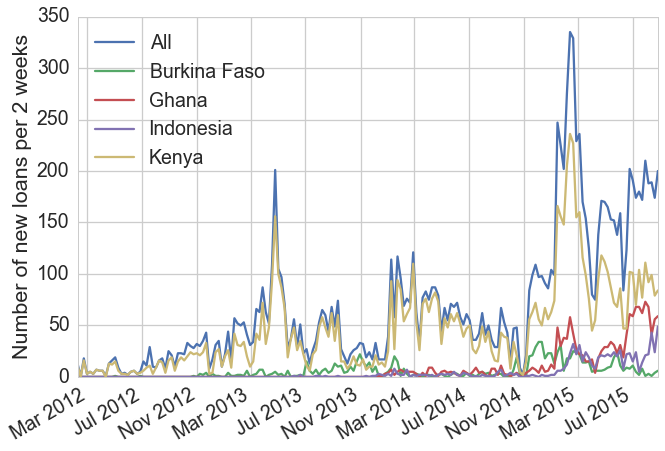

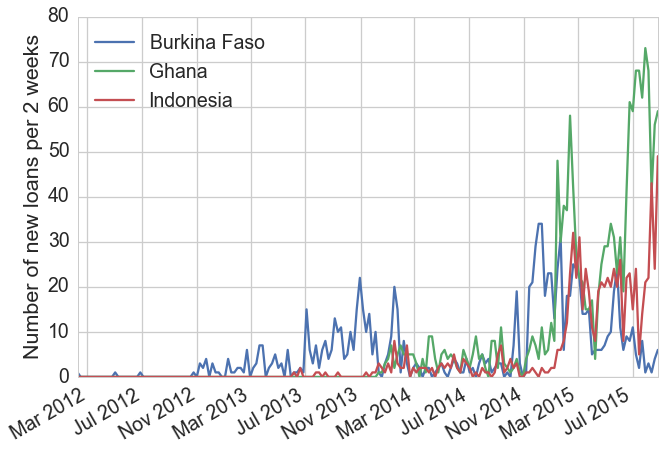

In [12]:
df_first_loans_count.plot()
plt.ylabel('Number of new loans per 2 weeks')
df_first_loans_count[['Burkina Faso', 'Ghana', 'Indonesia']].plot()
plt.ylabel('Number of new loans per 2 weeks')

In [ ]:
df_new_borrowers_count.plot()
plt.ylabel('Number of new borrowers per 2 weeks')

In [ ]:
df_loan_loss_fee_kenya.plot()
plt.ylabel('Kenya loan loss reserve fee (USD)')

In [ ]:
df_max_first_loan.plot()
plt.ylabel('Maxium first loan size (USD)')
plt.ylim([0, 200])

In [ ]:
df_max_invites.plot()
plt.ylabel('Maxium number of invitess')
plt.ylim([0, 11])

In [ ]:
b, a = sps.iirfilter(1, (0, 0.125))
fund_rate_feature = df_fund_rate.Kenya.values
raw_data = np.copy(fund_rate_feature)
init_cond_out = np.zeros(len(a)-1)
init_cond_in = np.zeros(len(b)-1)
mean_offset = np.mean(raw_data)
raw_data = sps.lfilter(b, a, raw_data-mean_offset, zi=sps.lfiltic(b, a, init_cond_out, x=init_cond_in))[0]+mean_offset
plt.plot(raw_data)
plt.plot(fund_rate_feature)


In [ ]:
# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 0
if lag > 0:
    invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
    fund_rate_feature = df_fund_rate.Kenya.values[:-lag].copy()
    max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[:-lag].copy()
    web_change = df_website_change.web_change.values[:-lag].copy()

    label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
    time_axis = time_bins_center[:-lag].copy()
elif lag < 0:
    invite_feature = df_total_borrowers.Kenya.values[:lag].copy() * df_max_invites.max_invites.values[:lag].copy()
    fund_rate_feature = df_fund_rate.Kenya.values[:lag].copy()
    max_loan_feature = df_max_first_loan.max_loan.values[:lag].copy()
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[:lag].copy()
    web_change = df_website_change.web_change.values[:lag].copy()

    label_array = df_new_borrowers_count.Kenya.values[-lag:].copy()
    time_axis = time_bins_center[:lag].copy()
else:
    invite_feature = df_total_borrowers.Kenya.values.copy() * df_max_invites.max_invites.values.copy()
    fund_rate_feature = df_fund_rate.Kenya.values.copy()
    max_loan_feature = df_max_first_loan.max_loan.values.copy()
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values.copy()
    web_change = df_website_change.web_change.values.copy()

    label_array = df_new_borrowers_count.Kenya.values.copy()
    time_axis = time_bins_center.copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 2
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, invite_feature, fund_rate_feature, max_loan_feature, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Max invites * total borrowers', 'x2: Fraction funded', 'x3: Maximum loan limit', 'x4: Loan loss fee', 'x5: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const','Max invites * total borrowers','Fraction funded','Maximum loan limit', 'Loan loss fee', 'Web change']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 5
if lag > 0:
    invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
    fund_rate_feature = df_fund_rate.Kenya.values[:-lag].copy()
    max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[:-lag].copy()
    web_change = df_website_change.web_change.values[:-lag].copy()

    label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
    time_axis = time_bins_center[:-lag].copy()
elif lag < 0:
    invite_feature = df_total_borrowers.Kenya.values[:lag] * df_max_invites.max_invites.values[:lag].copy()
    fund_rate_feature = df_fund_rate.Kenya.values[:lag].copy()
    max_loan_feature = df_max_first_loan.max_loan.values[:lag].copy()
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[:lag].copy()
    web_change = df_website_change.web_change.values[:lag].copy()

    label_array = df_new_borrowers_count.Kenya.values[-lag:].copy()
    time_axis = time_bins_center[:lag].copy()
else:
    invite_feature = df_total_borrowers.Kenya.values.copy() * df_max_invites.max_invites.values.copy()
    fund_rate_feature = df_fund_rate.Kenya.values.copy()
    max_loan_feature = df_max_first_loan.max_loan.values.copy()
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values.copy()
    web_change = df_website_change.web_change.values.copy()

    label_array = df_new_borrowers_count.Kenya.values.copy()
    time_axis = time_bins_center.copy()

fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 1
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, fund_rate_feature, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x2: Fraction funded', 'x4: Loan loss fee', 'x5: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const','Fraction funded', 'Loan loss fee', 'Web change']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 6
lag_comp = 0
fund_rate_feature = df_fund_rate.Kenya.values[lag_comp:-lag+lag_comp].copy()
lag_comp2 = 4
loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
lag_comp3 = 0
web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()

invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
time_axis = time_bins_center[:-lag].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 1
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, fund_rate_feature, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Fraction funded', 'x2: Loan loss fee', 'x3: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const','Fraction funded', 'Loan loss fee', 'Web change']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
#Fit of Kenya

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 2
lag_comp = 0
fund_rate_feature = df_fund_rate.Kenya.values[lag_comp:-lag+lag_comp].copy()
lag_comp2 = 0
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
lag_comp3 = 2
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()

invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
label_array = df_first_loans_count.Kenya.values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 0
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Data': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot()
plt.ylabel('Number of first loans')
plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

kenya_nlr = label_array.copy()

m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)


In [ ]:
#Fit of other countries

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 2
lag_comp = 0
fund_rate_feature = df_fund_rate.Kenya.values[lag_comp:-lag+lag_comp].copy()
lag_comp2 = 0
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
lag_comp3 = 2
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()

invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_first_loans_count.Indonesia.values[lag:].copy()
label_array += df_first_loans_count.Ghana.values[lag:].copy()
label_array += df_first_loans_count['Burkina Faso'].values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 1
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Data': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot()
plt.ylabel('Number of first loans')
plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)

other_nlr = label_array.copy()

In [ ]:
plt.plot(time_axis, kenya_nlr)
plt.plot(time_axis, other_nlr)


In [ ]:
# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 12
lag_comp = 12
max_loan_feature = df_max_first_loan.max_loan.values[lag_comp:]#-lag+lag_comp]
lag_comp2 = 8
loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2]
lag_comp3 = 0
web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3]

invite_feature = df_total_borrowers.Kenya.values[:-lag] * df_max_invites.max_invites.values[:-lag]
fund_rate_feature = df_fund_rate.Kenya.values[lag_comp:-lag+lag_comp]

label_array = df_new_borrowers_count.Kenya.values[lag:]
time_axis = time_bins_center[:-lag]

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 1
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(web_change)
    web_change = sps.lfilter(b, a, web_change-mean_offset, zi=filt_init)[0] + mean_offset


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, max_loan_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: Website change', 'x3: Max loan']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const', 'Loan loss fee', 'Website change', 'Max loan']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)

In [ ]:
plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

In [ ]:
#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const','Max invites * total borrowers','Fraction funded','Maximum loan limit']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
plot_lists.individual(bd.bin_data_frame_to_list(df_new_borrowers_count))

In [ ]:
for df in list_df_total_first_loans:
    df.plot()

In [ ]:
for index in range(len(labels_countries)):
    list_df_total_first_loans[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    if list_df_total_first_loans[index].max()[0] > 600:
        list_df_total_first_loans[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    print(labels_countries[index])
    plt.plot(time)
    list_df_new_borrowers_count[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    print(labels_countries[index])
    list_df_new_borrowers_count[index].plot()

In [ ]:
list_df_new_borrowers[1]

In [ ]:
for df in list_df_new_borrowers:
    print(type(df))

In [ ]:
df_new_borrowers.columns.tolist()[0]

In [ ]:
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

In [ ]:
df_new_borrowers_counts = bd.bin_count_time(time_bins_edge, list_df_new_borrowers[0])
df_new_borrowers_counts.plot()

In [ ]:
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
df_first_loans_counts = bd.bin_count_time(time_bins_edge, list_df_first_loans[0])
df_first_loans_counts.plot()

In [ ]:
plt.plot(time_bins_center, df_first_loans_counts.data_counts)
plt.plot(time_bins_center, df_new_borrowers_counts.data_counts)

In [ ]:
df_first_loans

In [ ]:
df_first_loans['index']

In [ ]:
tlag = pd.DataFrame({'tdiff': df_first_loans.index.values - df_first_loans.created_at.values}, index=df_first_loans.index)
tlag = pd.DataFrame({'tdiff': tlag.tdiff.values}, index=tlag.index.values)
tlag.plot()

In [ ]:
x=np.timedelta64(tlag.tdiff[0])
date=x.astype('timedelta64[s]')
date.astype(int)

In [ ]:
z_tables = zidisha_db.string_query('SHOW TABLES')
df_date_list = []
table_list = []
for index in range(len(z_tables)):
    table_str = z_tables.iloc[index, 0]
    table_cols = zidisha_db.string_query('SHOW COLUMNS IN '+table_str)
    try:
        row_count = zidisha_db.string_query('SELECT COUNT(*) FROM '+table_str).iloc[0, 0]
    except: # pymysql.err.InternalError:
        print('Error accessing table '+table_str)
    else:
        table_list.append((table_str, row_count, table_cols))
    
    date_cols = table_cols[table_cols['Type']=='datetime']
    field_list = []
    for row in range(len(date_cols)):
        field_list.append(date_cols.iloc[row, 0])
    if field_list:
        sql_str = 'SELECT '
        for field in field_list:
            sql_str += 'MAX('+field+'), MIN('+field+'),'
        sql_str = sql_str[:-1] + 'FROM '+table_str
        try:
            df_date = zidisha_db.string_query(sql_str)
        except:
            print('Error accessing table '+table_str)
        else:
            df_date_list.append((table_str, df_date))

In [ ]:
for table, row_count, cols in table_list:
    print(table, '\n')
    print(row_count, '\n')
    print(cols, '\n')

In [ ]:
for table, df in df_date_list:
    print(table, '\n', df, '\n')